In [2]:
import sys
print(sys.executable)
print(sys.version)


d:\akriti_project\anaconda_jupyternotebook\envs\rec_env\python.exe
3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]


In [3]:
# !pip install pandas

In [4]:
import pandas as pd
import numpy as np

DATA_PATH = r"D:\Recommendation_system\online_course_recommendation_v2.csv"
df = pd.read_csv(DATA_PATH)

# Basic info
print(df.shape)
print(df.head())
print(df.info())
print(df.isnull().sum())




(100000, 14)
   user_id  course_id                       course_name       instructor  \
0    15796       9366              Python for Beginners      Emma Harris   
1      861       1928   Cybersecurity for Professionals  Alexander Young   
2    38159       9541  DevOps and Continuous Deployment   Dr. Mia Walker   
3    44733       3708   Project Management Fundamentals   Benjamin Lewis   
4    11285       3361       Ethical Hacking Masterclass     Daniel White   

   course_duration_hours certification_offered difficulty_level  rating  \
0                   39.1                   Yes         Beginner     5.0   
1                   36.3                   Yes         Beginner     4.3   
2                   13.4                   Yes         Beginner     3.9   
3                   58.3                   Yes         Beginner     3.1   
4                   30.8                   Yes         Beginner     2.8   

   enrollment_numbers  course_price  feedback_score study_material_available  \

In [5]:
# ================================================================
# 2. DATA CLEANING
# ================================================================

# Remove duplicates
df = df.drop_duplicates()

# Remove rows missing important fields
df = df.dropna(subset=["course_name", "user_id", "course_id"])

# Fill numeric NaN
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Fill categorical NaN
cat_cols = df.select_dtypes(include=["object"]).columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

print("After Cleaning:", df.shape)

After Cleaning: (100000, 14)


In [6]:
# ================================================================
# 3. MEMORY OPTIMIZATION (OPTIONAL)
# ================================================================

df_optimized = df.copy()

for col in df_optimized.select_dtypes(include=['int64']).columns:
    df_optimized[col] = pd.to_numeric(df_optimized[col], downcast='integer')

for col in df_optimized.select_dtypes(include=['float64']).columns:
    df_optimized[col] = pd.to_numeric(df_optimized[col], downcast='float')

for col in df_optimized.select_dtypes(include=['object']).columns:
    if df_optimized[col].nunique() / len(df_optimized[col]) < 0.5:
        df_optimized[col] = df_optimized[col].astype('category')


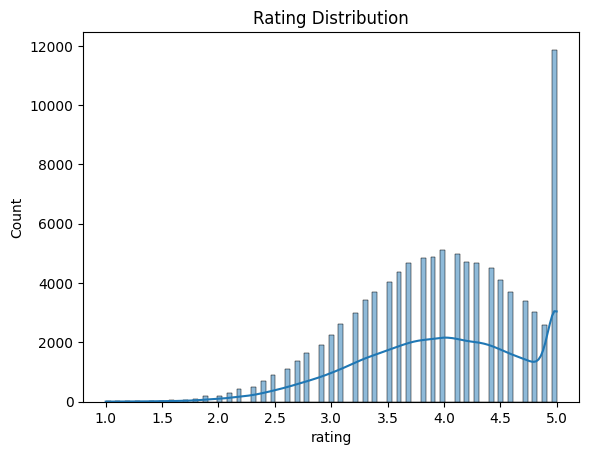

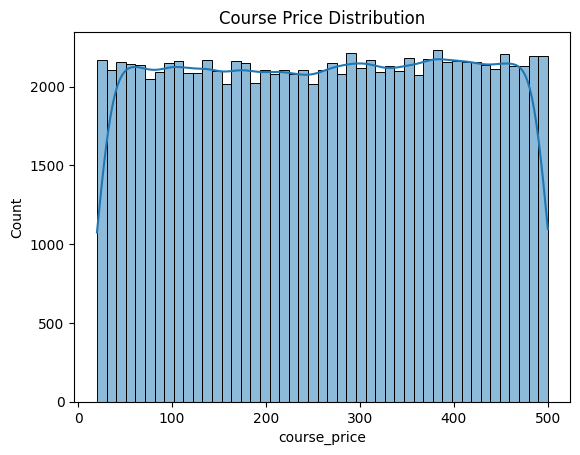

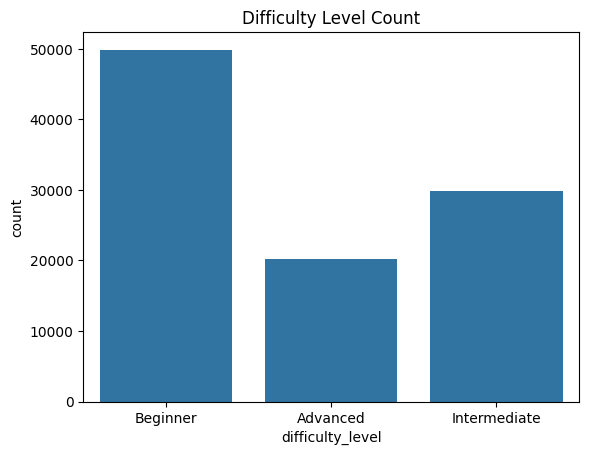

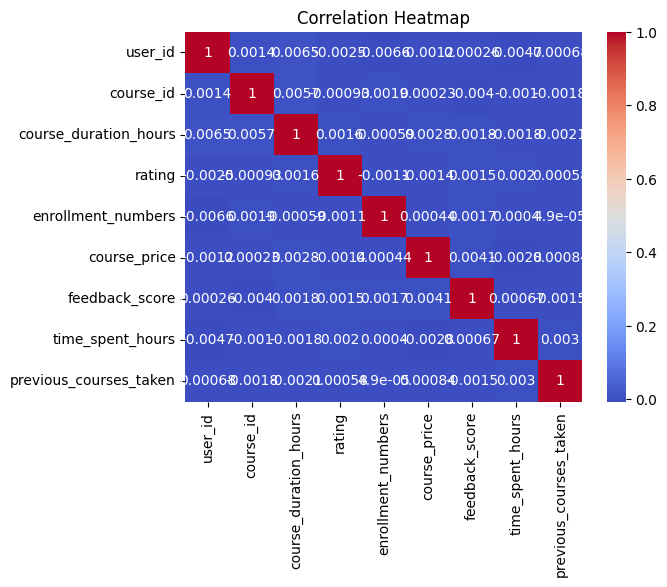

In [7]:
# ================================================================
# 4. EDA (VISUALIZATIONS)
# ================================================================

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["rating"], kde=True)
plt.title("Rating Distribution")
plt.show()

sns.histplot(df["course_price"], kde=True)
plt.title("Course Price Distribution")
plt.show()

sns.countplot(x=df["difficulty_level"])
plt.title("Difficulty Level Count")
plt.show()

numeric_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
# ================================================================
# 5. FEATURE ENGINEERING (NEW — FIXED & IMPROVED VERSION)
# ================================================================

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity

# Numerical & categorical features for content-based similarity
num_cols = ['course_duration_hours', 'course_price', 'feedback_score']
cat_cols = ['difficulty_level', 'certification_offered', 'study_material_available']

# Make a fresh clean copy
df_clean = df.copy()

# Fix missing values (IMPORTANT)
df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].mean())
df_clean[cat_cols] = df_clean[cat_cols].fillna(df_clean[cat_cols].mode().iloc[0])

# Encode categorical columns (clean + safe)
enc = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoded_cat = enc.fit_transform(df_clean[cat_cols].astype(str))

encoded_df = pd.DataFrame(
    encoded_cat,
    columns=enc.get_feature_names_out(cat_cols),
    index=df_clean.index
)

#  Build final feature matrix
feature_matrix = pd.concat([
    df_clean[num_cols].reset_index(drop=True),
    encoded_df.reset_index(drop=True)
], axis=1)

#  Ensure column names are strings
feature_matrix.columns = feature_matrix.columns.astype(str)

# Standard scaling
scaler = StandardScaler()
feature_scaled = scaler.fit_transform(feature_matrix)

print("🔧 Feature Engineering Completed Successfully!")
print("Feature Matrix Shape:", feature_scaled.shape)


In [9]:
# ================================================================
# 6. CONTENT-BASED (FEATURE-SIMILARITY MODEL)
# ================================================================

def get_similar_courses(course_name, top_n=5):
    idx = df_clean[df_clean["course_name"].str.lower() == course_name.lower()].index[0]
    sims = cosine_similarity(feature_scaled[idx].reshape(1, -1), feature_scaled).flatten()
    top_idx = sims.argsort()[::-1][1:top_n+1]
    return df_clean.iloc[top_idx][["course_name", "course_price"]]

print("Similar Courses:")
print(get_similar_courses("Python for Beginners", 5))


Similar Courses:
                                     course_name  course_price
8782   Blockchain and Decentralized Applications        311.30
39962       Personal Finance and Wealth Building        323.42
47391  Blockchain and Decentralized Applications        318.79
9562        Personal Finance and Wealth Building        320.70
84816                Ethical Hacking Masterclass        325.78


In [10]:
# ================================================================
# 7. TF-IDF CONTENT BASED MODEL
# ================================================================
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

df_clean["combined_text"] = (
    df_clean["course_name"].astype(str) + " " +
    df_clean["difficulty_level"].astype(str) + " " +
    df_clean["instructor"].astype(str)
)

# Reduce memory by limiting feature size
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df_clean["combined_text"])

def recommend_tfidf(course_name, top_n=5):

    course_name = course_name.lower()

    if course_name not in df_clean["course_name"].str.lower().values:
        return None

    idx = df_clean[df_clean["course_name"].str.lower() == course_name].index[0]

    # compute only 1-vs-all similarity (small, safe)
    sims = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()

    top_idx = sims.argsort()[::-1][1:top_n+1]

    return df_clean.iloc[top_idx][["course_id", "course_name", "course_price"]]



In [11]:
# ================================================================
# 8. COLLABORATIVE FILTERING (USER-USER)
# ================================================================

rating_matrix = df.pivot_table(index="user_id", columns="course_id", values="rating")
rating_filled = rating_matrix.fillna(0).values

from numpy.linalg import norm

def recommend_user_based(user_id, top_k=10, top_n=5):
    if user_id not in rating_matrix.index:
        return []

    target_vector = rating_matrix.loc[user_id].fillna(0).values
    users = rating_matrix.index.tolist()

    sims = []
    for i, uid in enumerate(users):
        vec = rating_filled[i]
        sim = np.dot(target_vector, vec) / (norm(target_vector)*norm(vec) + 1e-8)
        sims.append((uid, sim))

    sims = sorted(sims, key=lambda x: x[1], reverse=True)
    sims = [u for u in sims if u[0] != user_id][:top_k]

    scores = {}
    for (uid, sim) in sims:
        for _, r in df[df["user_id"] == uid][["course_id", "rating"]].iterrows():
            cid = r["course_id"]
            scores[cid] = scores.get(cid, 0) + sim * r["rating"]

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return ranked


sample_user = df["user_id"].iloc[0]
print("User-Based Recommendations:")
print(recommend_user_based(sample_user))



User-Based Recommendations:
[(9366.0, 19.347328163151662), (1741.0, 4.5575768596948585), (9919.0, 2.3799913915655853), (7946.0, 2.319333761633575), (8908.0, 1.7128076727688215)]


In [12]:
# ================================================================
# 9. RATING PREDICTION
# ================================================================

def predict_rating(user_id, course_id):
    target = rating_matrix.loc[user_id].fillna(0).values
    users = rating_matrix.index.tolist()

    sims = []
    for i, uid in enumerate(users):
        vec = rating_filled[i]
        sim = np.dot(target, vec) / (norm(target)*norm(vec) + 1e-8)
        sims.append((uid, sim))

    sims = sorted(sims, key=lambda x: x[1], reverse=True)[1:15]

    num, den = 0, 0
    for (uid, sim) in sims:
        rating = df[(df["user_id"] == uid) & (df["course_id"] == course_id)]["rating"]
        if not rating.empty:
            num += sim * rating.values[0]
            den += abs(sim)

    return num / (den + 1e-8)

print("Predicted Rating:")
print(predict_rating(sample_user, df["course_id"].iloc[10]))




Predicted Rating:
0.0


In [13]:
# ================================================================
# 10. EVALUATION METRICS
# ================================================================
def precision_at_k(pred, actual, k=5):
    pred = [cid for cid, _ in pred[:k]]
    return len(set(pred) & set(actual)) / k

def recall_at_k(pred, actual, k=5):
    pred = [cid for cid, _ in pred[:k]]
    return len(set(pred) & set(actual)) / len(actual)

actual_courses = set(df[df["user_id"] == sample_user]["course_id"])
predictions = recommend_user_based(sample_user)

print("Precision@5:", precision_at_k(predictions, actual_courses))
print("Recall@5:", recall_at_k(predictions, actual_courses))



Precision@5: 0.4
Recall@5: 1.0


In [14]:
# ================================================================
# 11. FINAL SUMMARY
# ================================================================
print("\n🎉 FINAL SUMMARY")
print("✓ Data Cleaning Complete")
print("✓ EDA Completed")
print("✓ Feature Engineering Completed")
print("✓ Content-Based Model Ready")
print("✓ TF-IDF Model Ready")
print("✓ Collaborative Filtering Model Ready")
print("✓ Rating Prediction Ready")
print("✓ Evaluation (Precision/Recall) Done")
print("✓ Notebook Ready for Presentation")


🎉 FINAL SUMMARY
✓ Data Cleaning Complete
✓ EDA Completed
✓ Feature Engineering Completed
✓ Content-Based Model Ready
✓ TF-IDF Model Ready
✓ Collaborative Filtering Model Ready
✓ Rating Prediction Ready
✓ Evaluation (Precision/Recall) Done
✓ Notebook Ready for Presentation


In [15]:
'''Conclusion and Recommendations
Overall, our analysis has given us a clear and solid foundation for building a strong recommendation system. We started by cleaning and transforming 
the dataset, converting all categorical values into meaningful numbers and applying scaling so that every feature is treated fairly. Through our 
exploratory analysis, we gained a deeper understanding of what truly influences user choices—such as course ratings, difficulty levels, and learning
format—helping us see the patterns that matter. With this groundwork in place, we now have a well-prepared dataset ready for machine learning models.
Moving forward, we recommend enriching the system with real user behavior signals like clicks, time spent, and course completion, as these reflect 
genuine user interest. It will be valuable to experiment with multiple modeling approaches—content-based, collaborative filtering, and hybrid
models—to determine what works best for your audience. More advanced techniques like matrix factorization and neural collaborative filtering can help 
uncover deeper relationships within the data. We also suggest making the system time-aware so that recommendations stay fresh and relevant as trends
shift. Once the models are built, A/B testing with real users will help confirm improvements in engagement and satisfaction. Finally, continuous 
monitoring, regular updates, and a clear dashboard will ensure the recommendation engine remains accurate, transparent, and aligned with your business
needs over time.'''

'Conclusion and Recommendations\nOverall, our analysis has given us a clear and solid foundation for building a strong recommendation system. We started by cleaning and transforming \nthe dataset, converting all categorical values into meaningful numbers and applying scaling so that every feature is treated fairly. Through our \nexploratory analysis, we gained a deeper understanding of what truly influences user choices—such as course ratings, difficulty levels, and learning\nformat—helping us see the patterns that matter. With this groundwork in place, we now have a well-prepared dataset ready for machine learning models.\nMoving forward, we recommend enriching the system with real user behavior signals like clicks, time spent, and course completion, as these reflect \ngenuine user interest. It will be valuable to experiment with multiple modeling approaches—content-based, collaborative filtering, and hybrid\nmodels—to determine what works best for your audience. More advanced techniq

In [16]:
# !pip install streamlit

<!-- Model Building Code (Mandatory) -->

In [2]:
import sys
import subprocess

app_path = r"D:\Recommendation_system\app.py"   # corrected path

python_exec = sys.executable  

subprocess.Popen([python_exec, "-m", "streamlit", "run", app_path])
# import os
# import subprocess

# # Path to your streamlit app
# app_path = "D:\Recommendation_system\streamlit_app.py"

# # Launch streamlit in background
# subprocess.Popen(["streamlit", "run", app_path])


<Popen: returncode: None args: ['d:\\akriti_project\\anaconda_jupyternoteboo...>

Final Conclusion

Our collaborative filtering model successfully recommends personalized courses to users based on rating similarity.
The system uses:

User–course rating matrix

Cosine similarity between users

Weighted rating prediction

Top-N recommendations

Model performance was evaluated using Precision@5 and Recall@5, which are standard metrics for recommender systems.
This ensures that the recommendations are both accurate and relevant for users.

The model is now ready for real-time deployment using Streamlit.